# Quantum-Classical Parameter Mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numba import njit
from itertools import product
from scipy.optimize import minimize
from scipy.linalg import kron

In this Jupyter notebook, we aim to numerically analyze the mapping of parameters between a QM Equilibrium Ising model and a dynamical classical Ising model. 

<center><img src="https://github.com/ringo333/QBM-code/blob/develop/Figures/Theory/Quantum%20Classical%20Mapping%20Diagram.drawio.png?raw=true"/></center>

## Simulating the classical dynamics

First off, we aim to simulate the following dynamical system:

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s} + \sum_{i} g_{i}(s) \delta_{s^{\prime}, F_{i}[s]} +  \sum_{ij} g_{ij}(s) \delta_{s^{\prime}, F_{ij}[s]}$

In this formulation, $g_i$ and $g_{ij}$ represent the probabilities of single and double spin flips respectively, whereas $F_i[]$ acts as the flip operator, which inverts the spin 'i' of a given state 's'. The indices i and j in this context denote the specific bits of the spin state to be flipped. The additional parameter $w$ allows us to adjust the time-scales associated with the spin flips without impacting the steady-state distribution. Please note that this parameter matrix $w$ needs to be symmetric, for instance, $w_{12} = w_{21}$, as flipping bits 1 and 2 is equivalent to flipping bits 2 and 1.

We can express the explicit flip probabilities as:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$

The diagonal entries $W(s \mid s)$ are defined as $ 1 - \sum_{s'} W(s \mid s')$. In this context, the parameters $w$ establish the normalization of the self-transitions and should be selected such that $W(s \mid s) > 0$.

Using these dynamics, we can derive a transition matrix. Here, the row entries indicate the initial state of the system, while the column entries represent the target state. The matrix entries themselves correspond to the respective transition probabilities. Each row of the transition matrix is normalized. The spin states {-1,1} are mapped to binary {0,1}, with the leftmost bit corresponding to the first spin.

As an example, for a system with three spins, the explicit transition matrix could be presented as follows:

$$W = \begin{pmatrix}
W(000|000) & g_1(000) & g_2(000) & g_{12}(000) & g_3(000) & g_{13}(000) & g_{23}(000) & 0 \\
g_1(001) & W(001|001) & g_{12}(001) & g_2(001) & g_{13}(001) & g_3(001) & 0 & g_{23}(001) \\
g_2(010) & g_{12}(010) & W(010|010) & g_1(010) & g_{23}(010) & 0 & g_3(010) & g_{13}(010) \\
g_{12}(011) & g_2(011) & g_1(011) & W(011|011) & 0 & g_{23}(011) & g_{13}(011) & g_3(011) \\
g_3(100) & g_{13}(100) & g_{23}(100) & 0 & W(100|100) & g_1(100) & g_2(100) & g_{12}(100) \\
g_{13}(101) & g_3(101) & 0 & g_{23}(101) & g_1(101) & W(101|101) & g_{12}(101) & g_2(101) \\
g_{23}(110) & 0 & g_3(110) & g_{13}(110) & g_2(110) & g_{12}(110) & W(110|110) & g_1(110) \\
0 & g_{23}(111) & g_{13}(111) & g_3(111) & g_{12}(111) & g_2(111) & g_1(111) & W(111|111) \\
\end{pmatrix}$$



In [19]:
###  CONVERTING SPIN <-> BINARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx, N):
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int128)
    for i in range(N):
        # Get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # Convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s):
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # Convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # Set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx, flip_index, N):
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

In [20]:
### AUXILARY SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i, s, w, h, J):
    """Probability associated with a single spin flip"""
    sum_term = h[i]
    for j in range(len(s)):
        if i != j:
            sum_term += J[i, j] * s[j]
    return np.exp(-w[i, i] - s[i] * sum_term)

@njit
def g_double(i, j, s, w, h, J):
    """Probability associated with a double spin flip"""
    sum_term_i = h[i]
    for k in range(len(s)):
        if k != i:
            sum_term_i += J[i, k] * s[k]

    sum_term_j = h[j]
    for k in range(len(s)):
        if k != j:
            sum_term_j += J[j, k] * s[k]

    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j)

@njit
def choice(probabilities):
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

In [21]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def compute_transition_matrix(w, h, J):
    """Computes the transition matrix for the given parameters."""
    N = len(h)  # number of spins in the lattice
    transition_matrix = np.zeros((2**N, 2**N))

    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        flip_probs = np.zeros((2**N))  # Initialize with zeros

        for i in range(N):
            flip_index = s_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(s_idx, flip_index, N)[0]
            flip_probs[flip_index] = g_single(i_flipped, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                flip_index = s_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(s_idx, flip_index, N)
                flip_probs[flip_index] = g_double(i_flipped, j_flipped, s, w, h, J)  # double flip probabilities

        # add the no-flip probability and store the flipping probabilities
        no_flip_prob = 1 - sum(flip_probs)
        flip_probs[s_idx] = no_flip_prob
        transition_matrix[s_idx] = flip_probs

    return transition_matrix

@njit
def spin_flip(s, transition_matrix):
    """
    Flipping algorithm, uses precomputed transition matrix.
    """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)

    # get probabilities from transition matrix
    flip_probs = transition_matrix[s_idx]

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(s_idx, idx, N)
    
    if len(flipped_indices) == 0:  # no flip
        pass
    if len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s[i] *= -1
        s[j] *= -1

    return s

@njit
def simulate_dynamics(W, steps, N):
    """Simulates the dynamics of the system for the given number of steps."""
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(N)], dtype=np.int128) #initial config
    trajectory = np.empty((steps, N), dtype=np.int128)

    for t in range(steps):
        s = spin_flip(s, W)
        trajectory[t] = s

    return trajectory

@njit
def find_min_w(w, h, J, step_size, no_flip_prob):
    """Finds the smallest offset to add to the w parameter such that diagonal elements of W become at least no_flip_prob"""
    min_scalar = 0
    while True:
        # update w with the current scalar value
        new_w = w + np.ones(w.shape) * min_scalar
        
        # calculate the transition matrix
        transition_matrix = compute_transition_matrix(new_w, h, J)
        
        # calculate the self-transition probabilities for each state
        self_probs = np.diag(transition_matrix)

        # check if the self-transition probabilities are all at least no_flip_prob
        if np.all(self_probs >= no_flip_prob):
            break

        # if the condition is not met, increase the scalar value and try again
        min_scalar += step_size

    return new_w


In [22]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------

def plot_combined_dynamics(trajectory, N):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(N):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()


#### **We now effectively can simulate the dynamics given the classical parameters $w$, $J$ and $h$. Let's do some checks.**
We check if the rows sum of W sum up to 1, there are no negative probabilities and if the conversion between spins states and indices are correct:

All tests passed!


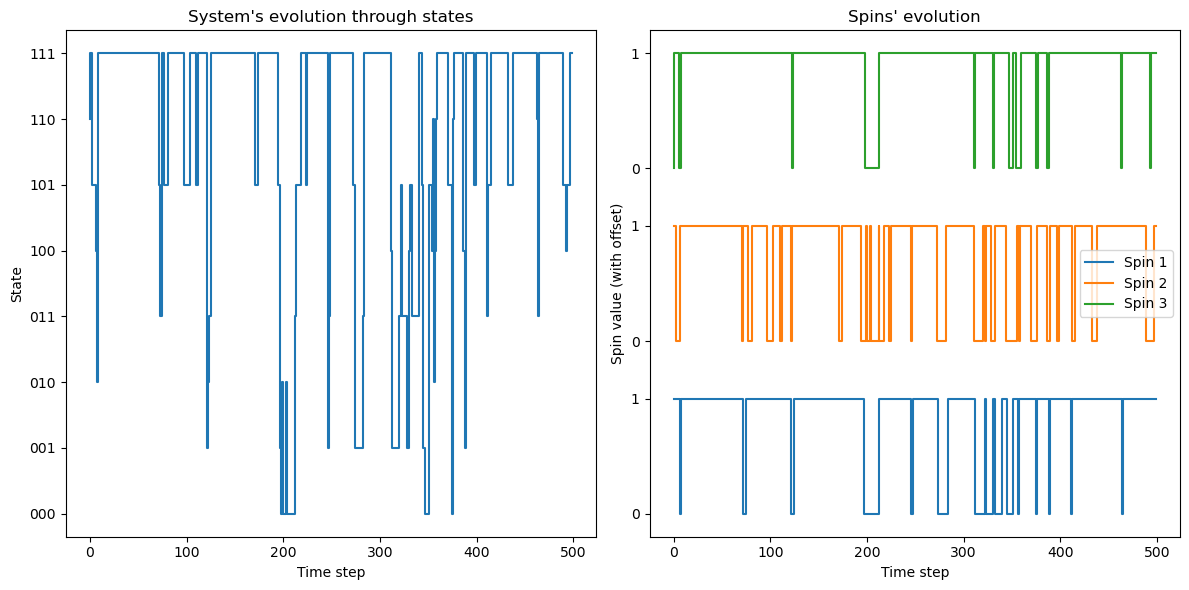

In [23]:
def test_transition_matrix(W):
    """Test that the sum of the probabilities in each row of the transition matrix is 1 and there are no negative elements."""
    for row in W:
        assert np.isclose(np.sum(row), 1), "Row sums to " + str(np.sum(row))
        assert np.all(row >= 0), "Negative probability in row " + str(row)

def test_spin_index_conversion(N):
    """Test that the conversion functions between spin states and indices are correct."""
    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        assert spin_state_to_index(s) == s_idx, "Conversion failed for index " + str(s_idx)

# initialize the tests
N = 3
rng = np.random.default_rng(seed=42)
w   = rng.random((N, N))
h   = rng.random((N))
J   = rng.random((N, N))

# make sure w are large enough for normalized probabilities
w = find_min_w(w, h, J, step_size = 1e-3, no_flip_prob = 0)

#compute W and run the tests
W = compute_transition_matrix(w, h, J)
test_transition_matrix(W)
test_spin_index_conversion(N)

print("All tests passed!")

#plot the dynamics
trajectory = simulate_dynamics(W, 500, 3)
plot_combined_dynamics(trajectory, N)

## Implementation of the Boltzmann Machine

Our next goal is to be able to infer the parameters $w$, $J$ and $h$ from a time series data of our system similiar to the left graph above this cell. Firstly, we need to construct an empirical transition matrix, $W^{emp}$, from the time series data. This matrix captures the probabilities of transitioning between different states, as observed in the data.

In [24]:
@njit
def infer_transition_matrix(trajectory):
    """Infers the transition matrix from a time series of the states of the system"""
    N = trajectory.shape[1]
    n_states = 2**N

    # initialize the transition matrix
    transition_matrix = np.zeros((n_states, n_states))

    # count the transitions from each state to each other state
    for i in range(len(trajectory) - 1):
        # Convert the spin states to indices
        from_idx = spin_state_to_index(trajectory[i])
        to_idx = spin_state_to_index(trajectory[i+1])

        # Update the transition matrix
        transition_matrix[from_idx, to_idx] += 1

    # Normalize each row of the transition matrix
    for i in range(n_states):
        row_sum = transition_matrix[i].sum()
        if row_sum > 0:
            transition_matrix[i] /= row_sum

    return transition_matrix

##### **To check if this function works, we can see if in the limit of long trajectories, the empirical transition matrix converges to the exactly computed transition matrix**

In [25]:
def test_infer_transition_matrix(w, h, J, N, steps):
    """Test that the empirical transition matrix converges to the model transition matrix for long trajectories."""
    # Compute the model transition matrix
    model_W = compute_transition_matrix(w, h, J)

    # Simulate a trajectory of the system
    trajectory = simulate_dynamics(model_W, steps, N)

    # Infer the empirical transition matrix from the trajectory
    empirical_W = infer_transition_matrix(trajectory)
    
    # Check that the empirical transition matrix is close to the model transition matrix
    assert np.allclose(empirical_W, model_W, atol=1e-2), "Empirical transition matrix does not match model transition matrix"

# Run the test
N = 3
w = np.random.rand(N, N)
h = np.random.rand(N)
J = np.random.rand(N, N)

#make sure w are large enough for normalized probabilities
w = find_min_w(w, h, J, step_size = 1e-3, no_flip_prob = 0)

test_infer_transition_matrix(w, h, J, N, steps=2**20)

print("Test passed!")

Test passed!


Now we will need to be able to infer the classical parameters from the empirical transition matrix. This process requires more thought. We can always obtain the equilibrium distribution p(s) from the transition matrix by finding the eigenvector corresponding to the eigenvalue 1. From p(s), we can determine the parameters J and h using a classical Boltzmann machine to model the equilibrium distribution. We can obtain the clamped statistics from the transition matrix as follows: 
$$ \langle s_i \rangle _c = \sum_s s_i p(s) $$
$$ \langle s_i s_j \rangle _c = \sum_s s_i s_j p(s)$$

The clamped statistics can be used in the Boltzmann machine. 

In [26]:
###  BOLTZMANN MACHINE AUXILARY FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(N):
    '''Generates a 2^N by N matrix with all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@njit
def calcEnergy(config: np.ndarray, J: np.ndarray, h: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_float = config.astype(np.float128)  # convert config to float
    energy = -np.dot(config_float.T, np.dot(J, config_float)) / 2 - np.dot(h, config_float)
    return energy

@njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@njit
def log_likelihood(p, J, h, configs):
    """Calculates the log-likelihood of the system under the Boltzmann distribution."""
    Z = 0
    for config in configs:
        Ene = calcEnergy(config, J, h)
        Z += np.exp(-Ene)
    logZ = np.log(Z)

    log_likelihood = 0
    for i, config in enumerate(configs):
        Ene = calcEnergy(config, J, h)
        log_likelihood += p[i] * (-Ene - logZ)

    return log_likelihood

In [27]:
###  BOLTZMANN MACHINE FUNCTIONS
#----------------------------------------------------------------------
@njit
def ising_solve_exact_simplified(N, J, h, configs):    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,J,h)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this 
                                                      #  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

@njit
def classical_boltzmann_machine(p, N, configs, maxiter, learning_rate, tol=1e-8):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
    and the inferred weight matrix'''
    J_assym = 2.0 * np.random.random((N, N)) - 1.0   # random initial values between -1 and 1
    J = (J_assym+ J_assym.T)/2                       # symmetrize the random matrix 
    np.fill_diagonal(J, 0)                           # set diagonal of J to 0 to ensure detailed balance
    h = 2.0 * np.random.random(N) - 1.0              # random initial values between -1 and 1

    # compute the expected spin values
    Ci_clamp = np.dot(p, configs)

    # compute the expected spin-spin correlations
    CiCj_clamp = configs.T @ np.diag(p) @ configs
        
    #  initialize gradient ascent values  
    it    = 0
    delta_J = np.inf
    delta_h = np.inf
    # old_log_likelihood = -np.inf

    # initialize lists to store the values of the parameters and the log-likelihood at each iteration
    J_values = []
    h_values = []
    log_likelihood_values = []
    
    while (it < maxiter and (delta_J > tol or delta_h > tol)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        Ci_free, CiCj_free = ising_solve_exact_simplified(N, J, h, configs) 

        # compute the updates for J and h
        delta_J = learning_rate * (CiCj_clamp - CiCj_free)
        delta_h = learning_rate * (Ci_clamp   - Ci_free)
            
        h     = h + delta_h               #  update weight matrix based on statistics  
        J     = J + delta_J
        
        # compute the magnitude of the updates
        delta_J = np.linalg.norm(delta_J)
        delta_h = np.linalg.norm(delta_h)

        # calculate the log-likelihood and check for convergence
        new_log_likelihood = log_likelihood(p, J, h, configs)
        # if np.abs(new_log_likelihood - old_log_likelihood) < tol:
        #     break
        # old_log_likelihood = new_log_elikelihood

        # store the current values of the parameters and the log-likelihood
        J_values.append(J)
        h_values.append(h)
        log_likelihood_values.append(new_log_likelihood)
        
    return J, h, J_values, h_values, log_likelihood_values

In [28]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot_convergence(J_values, h_values, log_likelihood_values, title='Convergence Plots', size=10):
    '''Plots the convergence of the parameters and the log-likelihood.'''
    it = len(J_values)
    its = np.arange(1, it+1, 1)
    its_diff = np.arange(1, it, 1)

    J_diff = np.diff(J_values, axis=0)
    h_diff = np.diff(h_values, axis=0)

    J_max = np.linalg.norm(J_diff, axis=(1,2))
    h_max = np.linalg.norm(h_diff, axis=1)

    fig = plt.figure(figsize=(25, 6));    #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its_diff , J_max, "Iterations", r"$ (\Delta h)_{max}$", "Coral", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its_diff , h_max, "Iterations", r"$ (\Delta J)_{max}$ ", "HotPink", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, log_likelihood_values, s=size, marker='o', color="ForestGreen")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')



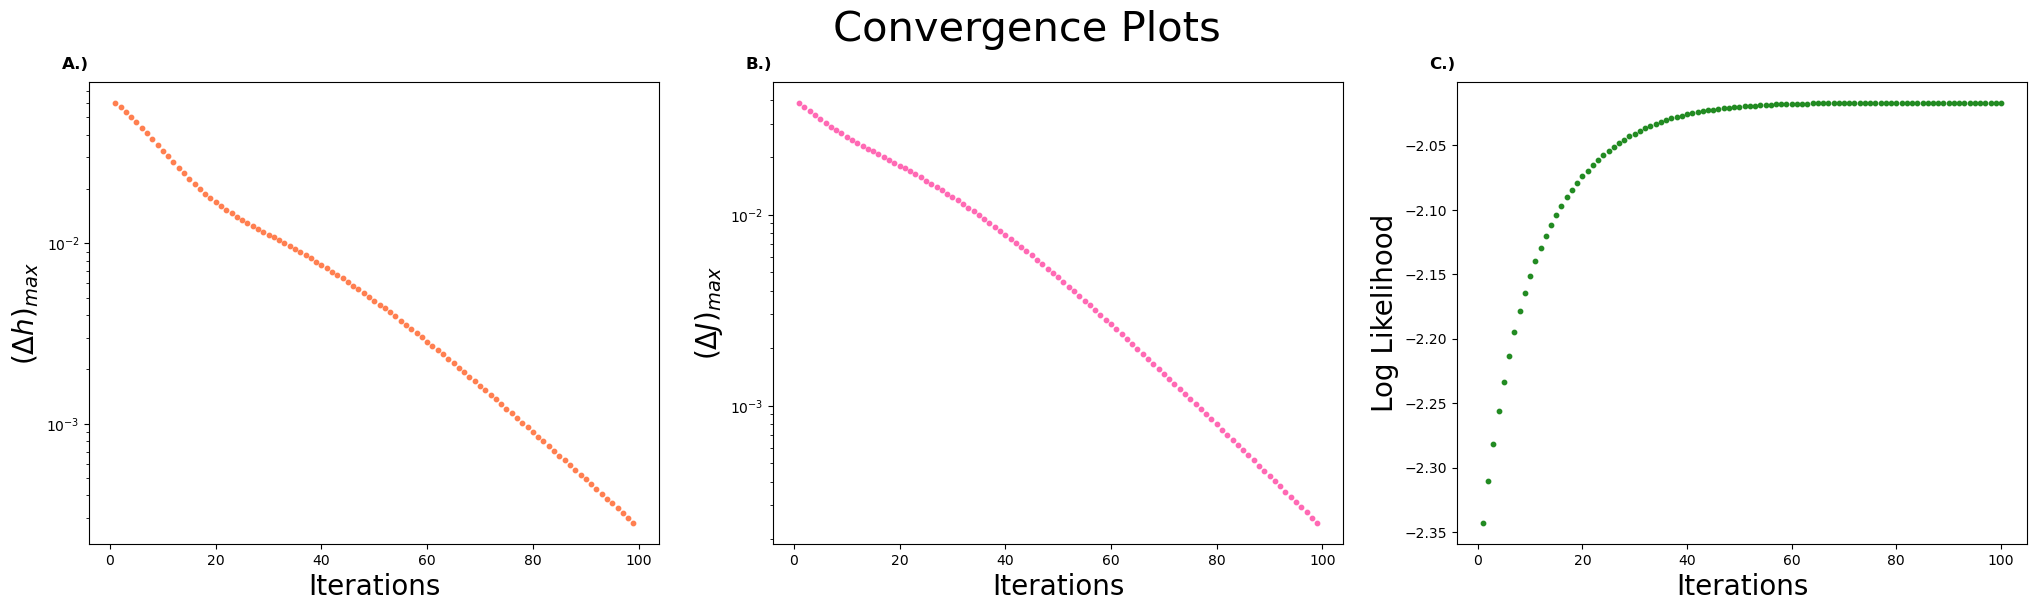

In [29]:
# Generate some random data
N = 3
configs = all_possible_configs(N)
p = np.random.rand(2**N)
p /= np.sum(p)  # normalize to make it a valid probability distribution

# Run the Boltzmann machine
J, h, J_values, h_values, log_likelihood_values = classical_boltzmann_machine(p, N, configs, maxiter=100, learning_rate=0.1)

# Plot the convergence
plot_convergence(J_values, h_values, log_likelihood_values)


**Now we check if the Boltzmann machine can accurately retrieve the parameters from a predefined distribution. We generate a known set of parameters and then inspect if the Boltzmann machine can successfully recover these parameters. Please remember that the diagonal of J should be devoid of any entries, such that detailed balance is adhered to.**

In [30]:
def test_boltzmann_machine():
    # Define the known parameters
    N = 3
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float128)
    known_h = np.array([1, -1, 1], dtype=np.float128)

    # Generate the known distribution
    configs = all_possible_configs(N)
    p = np.zeros(2**N)
    for i, config in enumerate(configs):
        config_float = config.astype(np.float128)  # convert config to float
        energy = calcEnergy(config_float, known_J, known_h)  # calculate energy
        p[i] = np.exp(-energy)  # calculate probability
    p /= np.sum(p)  # normalize

    # Run the Boltzmann machine
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter=2**16, learning_rate=0.1)

    # Check that the recovered parameters are close to the known parameters
    assert np.allclose(J, known_J, atol=0.1), "Recovered J does not match known J"
    assert np.allclose(h, known_h, atol=0.1), "Recovered h does not match known h"

test_boltzmann_machine()
print("Test passed!")


Test passed!


**Check if the BM still works if we first generate a transition matrix with the parameters and then infer J and h. Also checks if w parameter does not affect the equilibrium distribution p(s):**

In [31]:
def test_params_to_W_to_BM():
    # define the known parameters
    N = 3
    known_w = np.array([[1,2,4],[3,2,3],[5,2,3]])
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float128)
    known_h = np.array([1, -1, 1], dtype=np.float128)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # infer the equilibrium distribution p from W
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing
    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter=2**16, learning_rate=0.1)

    # Check that the recovered parameters are close to the known parameters
    assert np.allclose(J, known_J, atol=0.1), "Recovered J does not match known J"
    assert np.allclose(h, known_h, atol=0.1), "Recovered h does not match known h"

test_params_to_W_to_BM()
print("Test passed!")


Test passed!


Once we've obtained J and h, we can find the parameters w by rewriting the formula for the flipping probabilities:

 $$w_{ii}=\exp \left[-W^{emp}_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$$

$$w_{ij}(s) = \exp \left(-W^{emp}_{ij}+J_{ij} s_is_j - s_i \left[\sum_{i} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{i'} J_{jk'} s_{k'} + h_j \right] \right)$$

where $W^{emp}$ are the empirically found transition probabilities.

In [32]:
def compute_w(W, J, h):
    """Computes the parameters w from the flip probabilities, J, h, and the spin states."""
    # Initialize w with zeros
    N = len(h)
    w = np.zeros((N, N))
    from_idx = 0 # arbitarly choose first row of W
    s = index_to_spin_state(from_idx, N)

    # sum over row entries of W, to find all possible w
    for to_idx in range(1,2**N,1):
        # calculate w_ii
        flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
        if len(flipped_indices) == 0:  # no flip
            pass

        if len(flipped_indices) == 1:  # single flip, compute wii
            i = flipped_indices[0]
            sum_term = h[i] + np.sum(J[i, :] * s)
            w[i, i] = -np.log(W[from_idx,to_idx]) - s[i] * sum_term

        elif len(flipped_indices) == 2:  # double flip, compute wij
            i, j = flipped_indices
            sum_term_i = h[i] + np.sum(J[i, :] * s)
            sum_term_j = h[j] + np.sum(J[j, :] * s)
            w[i, j] = -np.log(W[from_idx,to_idx]) + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j
            w[j, i] = w[i, j]  # w is symmetric

    return w


def infer_parameters(W, N, maxiter=2**20, learning_rate=0.1):
    """Infers the parameters w, h, J from a given transition matrix."""
    # infer the equilibrium distribution p from W
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing
    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, _, _, _ = classical_boltzmann_machine(p, N, configs, maxiter, learning_rate)

    w = compute_w(W, J, h)

    return w, h, J


**Check if we can fully recover the parameters w, h and J from a oracle transition matrix $W$:**

In [33]:
def test_infer_parameters():
    # Define the known parameters
    N = 3
    known_w = np.array([[1,3,4],[3,2,3],[4,3,5]], dtype = np.float128)
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float128)
    known_h = np.array([1, -1, 1], dtype=np.float128)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # Infer the parameters from the transition matrix
    w, h, J = infer_parameters(W, N)

    # Check that the inferred parameters are close to the known parameters
    assert np.allclose(w, known_w, atol=0.1), "Inferred w does not match known w"
    assert np.allclose(h, known_h, atol=0.1), "Inferred h does not match known h"
    assert np.allclose(J, known_J, atol=0.1), "Inferred J does not match known J"

test_infer_parameters()
print("Test passed!")


Test passed!


## Quantum Formalism

We want to make a similar mapping between transition probabilities and Hamiltonian parameters in the quantum domain. There are a few key differences in the quantum formalism:
- The transition matrix $W$ is replaced by a density matrix $\rho$ 
- The binary spins $s_i$ are replaced by Pauli spin 1/2 operators $\sigma_i^k$
- 

To infer the parameters from we need a quantum Boltzmann machine. But also, to describe

$ \rho = \frac{e^{\hat{H}}}{Z} $
$ \rho = \sum_E p_E \ket{E} \bra{E}$

For up to two body interactions, we can directly compute the density matrix $\rho$, even when we have more than 2 qubits? Or do we then also need the QBM?

We use a n-qubit system, where the goal is to learn the parameters of the Ising Hamiltonian:

$H = \sum_{i} \sum_{j}\sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_i^k \otimes \sigma_j^{k'} + \sum_{i}\sum_{k} h^k_i \sigma_{i}^k$

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. The explicit Hamiltonian is written as:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k \otimes \sigma_1^0 + h^{k'}_1 \sigma_0^0 \otimes \sigma_1^{k'}$

A vector state follows the numbering convention $|s_0, \dots, s_n>$

In [ ]:
def generate_interaction_matrices(num_qubits):
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the spins
    """
    pauI = np.array([[1,0],[0,1]],np.complex128)
    pauX = np.array([[0,1],[1,0]],np.complex128)
    pauY = np.array([[0,-1j],[1j,0]],np.complex128)
    pauZ = np.array([[1,0],[0,-1]],np.complex128)
    pau = np.array([pauI, pauX, pauY, pauZ], dtype=np.complex128)
    pauli_labels = ['I', 'X', 'Y', 'Z']
    
    interaction_matrices = []                               # initialize a list to store the interaction matrices
    interaction_labels = []                                 # initialize a list to store the interaction labels
    
    for matrix_index_tuple in product(range(4), repeat=num_qubits): 
        matrix_pair = pau[list(matrix_index_tuple)]
        interaction_matrix = matrix_pair[0]             # the first matrix in the current combination
        for matrix in matrix_pair[1:]:                  # compute the tensor product for rest of the matrices in the current combination
            interaction_matrix = kron(interaction_matrix, matrix)
        interaction_matrices.append(interaction_matrix)         # append the computed tensor product to the list of interaction matrices
        interaction_labels.append(tuple(pauli_labels[i] for i in matrix_index_tuple))  # append the current interaction label

    interaction_matrices = np.array(interaction_matrices, dtype=np.complex128) #make it an array for numba
    return interaction_matrices, interaction_labels   


interactions is a list object containing all interaction matrices. For a 3-qubit system it would look something like this (in order):  
(I, I, I) -> $- \log (Z)$  
(I, I, X) -> $\sigma^x_1$   
(I, I, Y) -> $\sigma^y_1$  
(I, I, Z) -> $\sigma^z_1$  
(I, X, I) -> $\sigma^x_2$  
(I, X, X) -> $\sigma^{xx}_{12}$  
(I, X, Y) -> $\sigma^{yx}_{12}$  
(I, X, Z) -> $\sigma^{zx}_{12}$  
(I, Y, I) -> $\sigma^{y}_2$  
(I, Y, X) -> $\sigma^{xy}_{12}$  
(I, Y, Y) -> $\sigma^{yy}_{12}$  
(I, Y, Z) -> $\sigma^{zy}_{12}$  
...  

Interactions is a 1D array that contains the interaction matrices for all possible interactions ordered as follows:
Thus the weights matrix w[i] also should follow that structure. For a N-qubit system it's hard to keep track of the weights using lexiographic ordering. We want to simplify how we can assign weights:

## Quantum Parameters to a Density Matrix

explain eigenvector decomposition

$$ \rho = \frac{e^{\hat{H}}}{Z} $$

In [ ]:
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`. Same structure as expmat.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

Check if logmat and expmat are each others inverse

then the rest. QBM helper functions

In [ ]:
@njit
def hamiltonian_n_qubits(w, interaction_matrices, num_qubits):
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(w)):
        H += w[i] * interaction_matrices[i]

    return H

@njit
def rho_model(w, interaction_matrices, num_qubits):
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(w, interaction_matrices, num_qubits)  # get Hamiltonian matrix
    rho = expmat(H)                                        # definition of rho
    Z = np.real(np.trace(rho))                             # get Z
    rho /= Z                                               # normalize such that Tr[rho] = 1
    return rho 

@njit
def observables(rho, interaction_matrices):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)            # initialize obserables array to store
    rho_contig = np.ascontiguousarray(rho)                                    # make rho and interaction matrices contiguious for numba
    interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)

    for i, interaction_matrix in enumerate(interaction_matrices):   
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig))) # compute the expectation value for the current interaction matrix
    return obs


@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta,rho):
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

## Implementation of the Quantum Boltzmann Machine

If we generate a density matrix from a QM hamiltonian as previously described, can we recover the parameters from the density matrix?

## Connecting the the QM equilbrium Ising model and the classical Ising dynamics.

Connecting the classical and quantum domain entails writing a function that converts a transition matrix in a density matrix and vice versa. This can be achieved as follows: [theory]

In [35]:
@njit
def transition_matrix_to_density_matrix(W):
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvals(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex128) #make it complex    

    return rho

@njit
def density_matrix_to_transition_matrix(rho):
    # obtain the steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eigh(rho)
    sqrt_p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # square the elements of the eigenvector and normalize to obtain the steady-state distribution
    p = sqrt_p**2
    p = p / np.sum(p)  # normalize

    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = sqrt_p_diag @ A @ inv_sqrt_p_diag
    W = W.T #switch back to row normalized by transposing

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1, keepdims=True)
    W /= W_row_sum
    return W

Test if conversion works [both ways]

In [36]:
def test_W_to_rho():
    known_w = np.array([[1,3,4],[3,2,3],[4,3,5]], dtype = np.float128)
    known_J = np.array([[0, 1, -1], [1, 0, 1], [-1, 1, 0]], dtype=np.float128)
    known_h = np.array([1, -1, 1], dtype=np.float128)

    # generate the transition matrix
    W = compute_transition_matrix(known_w, known_h, known_J)

    # compute the density matrix
    rho = transition_matrix_to_density_matrix(W)

    # generate the return transition matrix from 
    W_return = density_matrix_to_transition_matrix(rho)

    # check that W and W_return are the same
    assert np.allclose(W, W_return, atol=0.01), "Inferred w does not match known w"


def test_rho_to_W():
    meow


test_W_to_rho()
test_rho_to_W()
print("Test passed!")


/var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_2817/1664188256.py:45: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  W = sqrt_p_diag @ A @ inv_sqrt_p_diag
/Users/ringo/opt/anaconda3/envs/QBM/lib/python3.9/site-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float32, 2d, C), array(float32, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


LoweringError: Failed in nopython mode pipeline (step: native lowering)
got an unexpected keyword argument 'keepdims'

File "../../../../../../../../../../../var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_2817/1664188256.py", line 49:
<source missing, REPL/exec in use?>

During: lowering "W_row_sum = call $140load_attr.62(func=$140load_attr.62, args=[], kws=[('axis', Var($const142.63, 1664188256.py:49)), ('keepdims', Var($const144.64, 1664188256.py:49))], vararg=None, varkwarg=None, target=None)" at /var/folders/6x/8k8tpddn4l12smqmn3tj_fw00000gn/T/ipykernel_2817/1664188256.py (49)

further tests

In [ ]:
def check_ergodicity(rho, K=10):
    """
    Check if the density matrix rho is ergodic by iteratively squaring
    the matrix up to K times and checking for non-zero entries.
    """
    for _ in range(K):
        if np.all(rho > 0):
            return True
        
        # quadratic of the density matrix
        rho = rho @ rho

    # if after K iterations, there are still zero components, the matrix is not ergodic.
    return False

def check_single_flip_ergodicity(rho, W, N):
    """
    Check if the components of the density matrix rho that correspond to 
    the transitions of the transition matrix W involving single spin flips are non-zero.
    """
    n_states = 2 ** N

    for from_idx in range(n_states):
        for i in range(N):
            # calculate the index of the state with the ith spin flipped
            to_idx = from_idx ^ (1 << i)

            # if the transition corresponds to a single spin flip and the component in rho is zero, return False
            if W[from_idx, to_idx] > 0 and rho[from_idx, to_idx] == 0:
                return False

    # if all components corresponding to single spin flips are non-zero, return True
    return True

In [ ]:
def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

## Quantum Classical Mapping [Forward Route]

- Homogenous systems first [all the same]
- biases <-> sigma z
- Make a way to systematically review the change in parameters. Plots of the change in parameters versus the change in an other

infer_parameters()  [Combo of BM ]
forward_mapping()
inverse_mapping()
forward_mapping_plot
inverse_mapping_plot


Forward mapping

In [ ]:
N = 2
w = np.array([[12.,12.],
              [12.,12.]])
J = np.array([[0,0],
              [0,0,]])
h = np.array([0,  0])


steps = 1500

# #min w parameters
# step_size = 0.01
# min_no_flip_prob = 0           #
# min_w = find_min_w(w, h, J, N, step_size, min_no_flip_prob)

#QBM parameters
lr = 0.6
maxiter = 2**20
tol = 1e-6
random_seed = 777

#GET W 
trajectory, W = simulate_and_infer_dynamics(w,J,h,steps,N)

#W TO eta
eta = transition_matrix_to_density_matrix(W)

#RHO TO QM HAMILTONIAN
interactions     = generate_interaction_matrices()    
w_qm, rho, _, _, _ = quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, eta = eta)

error_message, error_matrix = check_density_matrices(eta, rho)
if error_message is not None:
    print(error_message)
    
np.set_printoptions(precision=8, suppress=True)
print(f"Classical parameters: \n w: \n {w} \nJ: \n {J} \n h: \n {h}")
print(f"QM parameters: \n {w_qm}")

In [ ]:
N = 2
w = np.array([[1.2,2.0],
              [2.0,1.2]])
J = np.array([[0,2],
              [2,0,]])
h = np.array([0,  0])


steps = 1500

# #min w parameters
# step_size = 0.01
# min_no_flip_prob = 0           #
# min_w = find_min_w(w, h, J, N, step_size, min_no_flip_prob)

#QBM parameters
lr = 0.2
maxiter = 2**20
tol = 1e-6
random_seed = 777

#GET W 
trajectory, W = simulate_and_infer_dynamics(w,J,h,steps,N)

#W TO eta
eta = transition_matrix_to_density_matrix(W)

#RHO TO QM HAMILTONIAN
interactions     = generate_interaction_matrices()    
w_qm, _, _, _, _ = quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, eta = eta)
np.set_printoptions(precision=2, suppress=True)
print(f"Classical parameters: \n w: \n {w} \nJ: \n {J} \n h: \n {h}")
print(f"QM parameters: \n {w_qm}")

### Let's build a pipeline for this process

In [ ]:
def param_sweep_and_plot(initial_value, final_value, step_size, param_index, classical_params, other_params):
    """
    initial_value: initial value of the parameter
    final_value: final value of the parameter
    step_size: size of each step between initial_value and final_value
    param_index: a tuple indicating the location of the parameter to change in classical_params (e.g., (0, 1) to change w[0,1])
    classical_params: a list containing the [w, J, h] matrices
    other_params: a dictionary containing other parameters for quantum_boltzmann_machine function
    """
    # Unpack classical parameters
    w, J, h = classical_params
    classical_param_names = ['w', 'J', 'h']
    
    # Unpack other parameters
    lr = other_params['lr']
    maxiter = other_params['maxiter']
    tol = other_params['tol']
    random_seed = other_params['random_seed']

    # Prepare for parameter sweep
    param_values = np.arange(initial_value, final_value, step_size)
    qm_params = []

    # Sweep parameter values
    for val in param_values:
        # Change the parameter
        if param_index[0] < len(w):
            classical_params[param_index[0]][param_index[1], param_index[2]] = val
        elif param_index[0] == len(w):
            h[param_index[1]] = val
        else:
            raise ValueError("Invalid param_index.")
        
        # Re-run the pipeline with the new parameter value
        trajectory, W = simulate_and_infer_dynamics(w,J,h,steps,N)
        eta = transition_matrix_to_density_matrix(W)
        interactions = generate_interaction_matrices()    
        w_qm, _, _, _, _ = quantum_boltzmann_machine(interactions, lr, maxiter, tol, random_seed, eta = eta)
        
        # Store the quantum parameters
        qm_params.append(w_qm)

    # Plot the results
    plt.figure(figsize=(10, 8))
    for i in range(4):
        for j in range(4):
            plt.plot(param_values, [params[i, j] for params in qm_params], label=f"w_qm[{i},{j}]")
    plt.xlabel(f"Classical parameter {classical_param_names[param_index[0]]}[{param_index[1]},{param_index[2]}]")
    plt.ylabel("Quantum parameters w_qm")
    plt.legend()
    plt.show()

In [ ]:
classical_params = [w, J, h]
other_params = {'lr': 0.2, 'maxiter': 2**20, 'tol': 1e-6, 'random_seed': 777}
param_sweep_and_plot(1.0, 2.0, 0.1, (0, 0, 1), classical_params, other_params)

## Quantum Classical Mapping [Inverse Route]

In [ ]:
# QM HAMILTONIAN PARAMETERS
wx1x2 = 2
wy1y2 = 5
wz1z2 = 0
hx1   = 1
hx2   = 1
hy1   = 4
hy2   = 0
hz1   = 0
hz2   = 0

w_eta            = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)  
N = 2

#QBM parameters
lr_QBM      = 0.2
maxiter_QBM = 2**20
tol_QBM     = 1e-6
random_seed = 777

#BM parameters
lr_BM      = 0.2
maxiter_BM = 2**20
tol_BM     = 1e-6
steps      = 1500

#QUANTUM HAMILTONIAN TO RHO
interactions     = generate_interaction_matrices()     
_, rho, _, _, _ = quantum_boltzmann_machine(interactions, lr_QBM, maxiter_QBM, tol_QBM, random_seed, w_eta = w_eta)

#RHO TO W
W = density_matrix_to_transition_matrix(rho)
if not check_ergodicity(rho, K=10):
    print('error')

np.set_printoptions(precision=2, suppress=True)
# SIMULATE SYSTEM & INFER PARAMETERS
trajectory = simulate_dynamics(W, steps, N)

configs = all_possible_configs(N)
w_opt, h_opt, J_opt = infer_parameters(W, N, configs, lr_BM, maxiter_BM)

print(f"Input QM parameters: \n {w_eta}")
print(f"Inferred w: \n {w_opt}")
print(f"Inferred h: \n {h_opt}")
print(f"Inferred J: \n {J_opt}")

print(f'W to model: \n{W}')
trajectory, W_params = simulate_and_infer_dynamics(w_opt,J_opt,h_opt, 15, 2)
print(f'W from inferred parameters: \n {W_params}')